# Exercise 1: 
# Constructing a Multislice RF Shimming App

Welcome to Exercise 1! Here we'll gain familiarity with the abstractions used to build optimization-based iterative methods by building our own Apps for RF Shimming. Although some pulse design problems involve direct design, many require nonlinear optimization methods. SigPy's abstractions are perfect for neatly handling these pulse design problems! This demo will move quickly- visit the [hyperlinked documentation](https://sigpy.readthedocs.io/en/latest/) throughout the notebook to get more information on specific tools used.

SigPy provides three supporting classes for building iterative reconstruction [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App)'s: 

- [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop) for linear operator
- [Prox](https://sigpy.readthedocs.io/en/latest/generated/sigpy.prox.Prox.html#sigpy.prox.Prox) for proximal operator
- [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg) for iterative algorithms

Here we will cover Linops, Algs, and Apps. For more information on applying the Prox abstraction, please view [this tutorial](https://github.com/mikgroup/sigpy-mri-tutorial) (especially part 3).

<!-- Also, we'd like to note that SigPy has a LOT of features that we don't have time to talk about today! These include:
 -->

## Setup

Let us first import relevant packages and load a set of $B_1^+$ maps for a simulated 7T 8-channel transmit head coil. We'll shim slice-by-slice over 3 slices in the middle of the head.

In [75]:
%matplotlib notebook
import sigpy as sp
import sigpy.mri.rf as rf
import sigpy.plot as pl
import numpy as np

sens = np.load('data/LoopTx8_B1p_Axial_3slice.npy')
mask = (np.abs(sens) > 0).astype(complex)[1,:,:,:]
mask = np.transpose(mask,(2,0,1))

Nc = sens.shape[0]
dim = sens.shape[1]
img_shape = [dim, dim]
Ns = sens.shape[3]
print('B1p map shape = {}'.format(sens.shape))
print('Mask shape = {}'.format(target.shape))

B1p map shape = (8, 101, 101, 3)
Mask shape = (101, 3)


Let's take a glance at the B1 maps for a single slice. SigPy's [plotting functions](https://sigpy.readthedocs.io/en/latest/plot.html) have hotkeys that allow us to:
* look at the magnitude 'm', real 'r', imaginary 'i', or phase 'p' component of an image
* move through an axis with the arrow keys

Click on image plotted with the next line of code and try it out! 

<IPython.core.display.Javascript object>


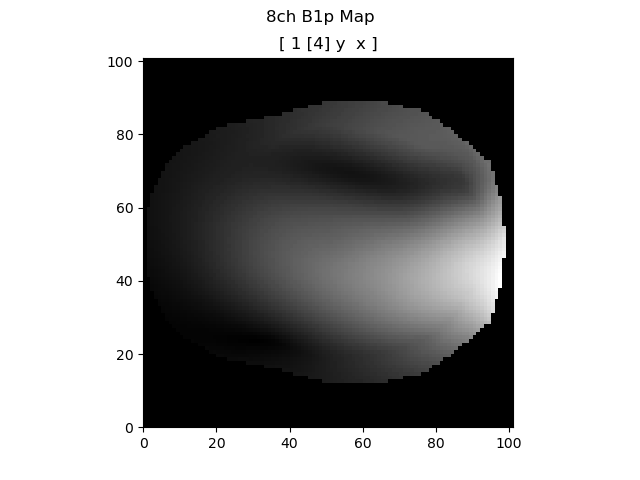

In [76]:
pl.ImagePlot(np.transpose(sens,(3, 0, 1, 2)), title='8ch B1p Map')

We would like to use the superposition of these eight transmit fields to produce a homogeneous overall transmit field by the adjustment of the magnitudes and phases of individual transmit elements. Let's build two Apps to try and find the optimal weights - once with a **Linear Least Squares Algorithm**, and once with a **Magnitude Least Squares Algorithm**! 

 In a Linear Least Squares form, the problem of RF shimming can be written as:
 $$b = \min_b \frac{1}{2} \| A b - m \|_w^2 + R(b)$$
 
 Where $A$ is the parallel transmission system matrix, $m$ is target profile in space, and $b$ is the vector of complex weights corresponding to each transmit channel. $R(b)$, a regularization term, and $w$, a weighting over a region of interest, may also be included.
 
 ## Linop
 
 First, let's build our $A$ Linear Operator. Linear operators are abstracted in the class [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop). Given a Linop A, and an appropriately shaped input x, we can compute x -> A(x) by:

       >>> y = A(x)
       or
       >>> y = A * x

Its adjoint linear operator can be obtained using the `.H` attribute. Linops can be scaled, added, subtracted, stacked and composed.

We can make the [pTx linear operator](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.rf.linop.PtxSpatialExplicit.html#sigpy.mri.rf.linop.PtxSpatialExplicit) $A$ for just one head slice with the line below. Because we are simply shimming with static weights and not following an excitation k-space trajectory, our 'coord' argument is simply a single 0 - we are right at DC. 'dt' is also meaningless in this problem, since the shim is static.


In [77]:
k = np.zeros((1,2),dtype=complex)
A_slice = rf.PtxSpatialExplicit(sens[:, :, :, 0], coord=k, dt=0,
                                img_shape=img_shape)
print('A_slice input shape = {}'.format(A_slice.ishape))
print('A_slice output shape = {}'.format(A_slice.oshape))


A_slice input shape = [8, 1]
A_slice output shape = [101, 101]


We want to shim all of our slices simultaneously, so let's diagonally stack the $A$ linear operator for each slice with [sp.linop.Diag](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Diag.html#sigpy.linop.Diag). Diag creates a new linop that splits an input, applies each component linop independently, and concatenates the outputs.

In [78]:
As = []
for ii in range(Ns):
    A_slice = rf.PtxSpatialExplicit(sens[:, :, :, ii], coord=k, dt=0,
                                    img_shape=img_shape)
    As.append(A_slice)

A = sp.linop.Diag(As)

print('A input shape = {}'.format(A.ishape))
print('A output shape = {}'.format(A.oshape))

A input shape = [24]
A output shape = [30603]


Let's just take a guess at a good shim first- how about a circularly polarized "birdcage mode" shim, where our amplitudes are equal but our coil phases are aligned in the center of the head. We can input it to the linear operator...

<IPython.core.display.Javascript object>


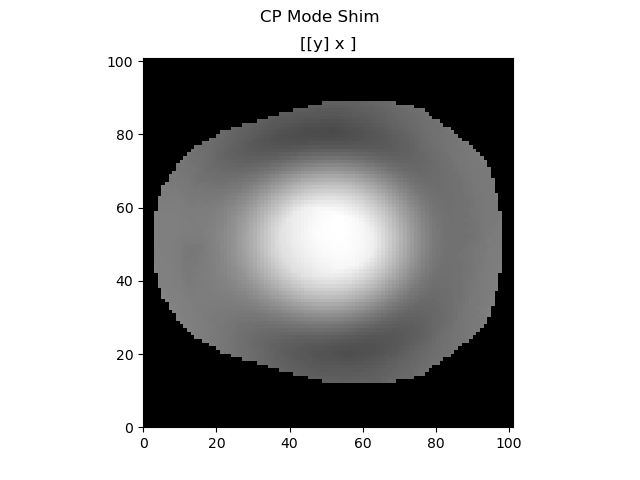

In [79]:
guess_shim = rf.init_circ_polar(sens[:,:,:,0])
m = A_slice * guess_shim
pl.ImagePlot(m, title='CP Mode Shim')

Well - that's not very uniform. Let's try a a LLS approach now.

In a Linear Least Squares form, the problem of RF shimming can be written as:
 $$x = \min_x \frac{1}{2} \| A x - m \|_w^2 + R(x)$$
 
 Where $A$ is the parallel transmission system matrix, $m$ is target profile in space, and $x$ is the vector of complex weights corresponding to each transmit channel. $R(x)$, a regularization term, and $w$, a weighting over a region of interest, may also be included (although we will not demonstrate their use here).

## Alg 
 [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg) abstracts iterative algorithms. The standard way of using an [Alg](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.Alg.html#sigpy.alg.Alg), say 'alg', is as follows:

    >>> while not alg.done():
    >>>     alg.update()

The user is free to run other things in the while loop.

For our LLS Algorithm, let's use a [Conjugate Gradient](https://sigpy.readthedocs.io/en/latest/generated/sigpy.alg.ConjugateGradient.html#sigpy.alg.ConjugateGradient) optimizer. We can test it first using our single-slice $A$ linop:

CG Design, Iteration=8

<IPython.core.display.Javascript object>


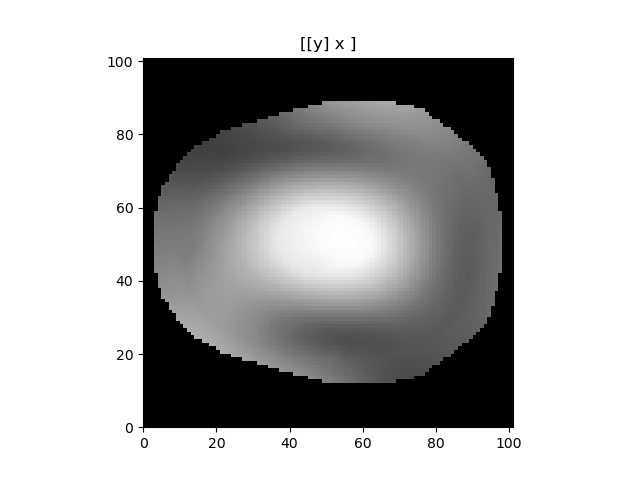

In [80]:
max_iter = 100
tol = 1e-7

target = mask[0, :, :]
x0 = np.zeros((Nc,1)) + 1j * np.zeros((Nc,1))

alg = sp.alg.ConjugateGradient(A_slice.H * A_slice, A_slice.H * target,
                                        x0, max_iter=max_iter, tol=tol)

while not alg.done():
    alg.update()
    print('\rCG Design, Iteration={}'.format(alg.iter), end='')

pl.ImagePlot(A_slice * alg.x)

Better, but still not great - maybe it's a fluke? Let's make an App that shims all of the slices and see.

## App

An App is the highest level tool for deploying code for pulse design or reconstruction. It provides a simple interface to use applications. The standard way to run an [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App), say app, is as follows:

    >>> app.run()

Each [App](https://sigpy.readthedocs.io/en/latest/generated/sigpy.app.App.html#sigpy.app.App) must have a core Alg object. The `run()` function runs the Alg, with additional convenient features, such as a progress bar, which can be toggled with the `show_pbar` option.

We will copy the codes from above, including our stacked linear linear operator, and form a`ShimLLS` App.

In [64]:
class ShimLLS(sp.app.App):
    def __init__(self, sens3d, target, x0, max_iter=100, tol=1e-7, show_pbar=True):
        self.sens = sens3d
        self.target = target.flatten()
        self.x = x0
        self.max_iter = max_iter
        self.tol = tol
        self.show_pbar = show_pbar

        device = sp.get_device(sens)
        self.device = sp.Device(device)

        k = np.zeros((1,3),dtype=complex)
        As = []
        for ii in range(sens.shape[3]):
            A_slice = rf.PtxSpatialExplicit(sens[:, :, :, ii], coord=k, dt=0, img_shape=img_shape)
            As.append(A_slice)

        self.A = sp.linop.Diag(As)

        # solving A.H * A * x = A.H * m
        with self.device:
            self.alg = sp.alg.ConjugateGradient(self.A.H * self.A, self.A.H * self.target,
                                                self.x,
                                                max_iter=max_iter, tol=tol)

        super().__init__(self.alg, show_pbar=show_pbar)

    def _summarize(self):
        if self.show_pbar:
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))

    def _output(self):
        return self.x

ShimLLS:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


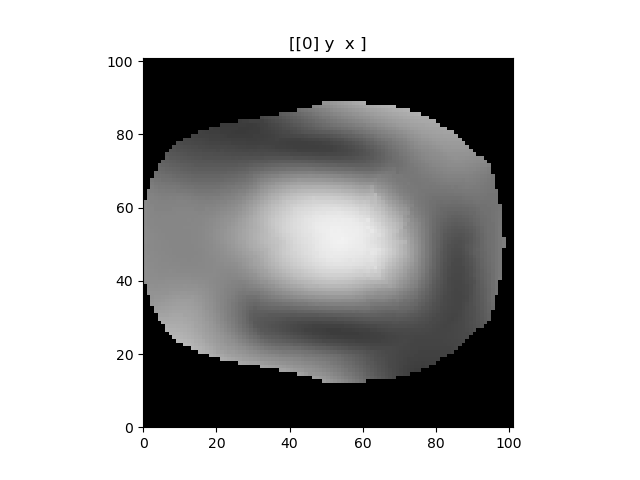

In [81]:
x0 = np.zeros((Nc*Ns), dtype=complex)  # initial shim
x_lls = ShimLLS(sens, mask, x0, show_pbar=True).run()
m = np.reshape(A*x_lls, (Ns, dim, dim))
pl.ImagePlot(m)

Our shim solutions aren't very uniform for any of the slices. However, in Let's try this again, but with a Magnitude Least Squares optimization, where we aren't so concerned with the phase of the profile. The MLS shimming problem is formulated as: 

 $$b = \min_b \frac{1}{2} \| |A b| - m \|_w^2 + R(b)$$
 
Although this optimization problem is non-convex, it can be reformulated and solved using the Gerchberg-Saxton algorithm:

GS Design, Iteration=100

<IPython.core.display.Javascript object>


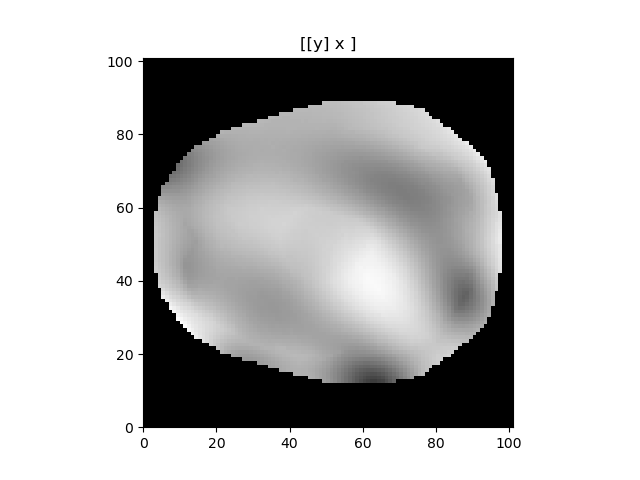

In [82]:
max_iter = 100
tol = 1e-7

target = mask[0,:,:]
x0 = np.zeros((Nc,1)) + 1j * np.zeros((Nc,1))

alg = sp.alg.GerchbergSaxton(A_slice, target, x0, max_iter=max_iter,
                             tol=tol)

while not alg.done():
    alg.update()
    print('\rGS Design, Iteration={}'.format(alg.iter), end='')

pl.ImagePlot(A_slice * alg.x)

That looks a lot better! now let's make a MLS multislice shimming App with the same form as our LLS App, and compare the results.

In [84]:
class ShimMLS(sp.app.App):
    def __init__(self, sens3d, target, x0, max_iter=100, tol=1e-7, show_pbar=True):
        self.sens = sens3d
        self.target = target.flatten()
        self.x = x0
        self.max_iter = max_iter
        self.tol = tol
        self.show_pbar = show_pbar

        device = sp.get_device(sens)
        self.device = sp.Device(device)

        coord = np.zeros((1,3),dtype=complex)
        self.target = np.ones((dim*dim*Ns), dtype=complex)
        As = []
        for ii in range(sens.shape[3]):
            A_slice = rf.PtxSpatialExplicit(sens[:, :, :, ii], coord, dt=4e-6, img_shape=img_shape)
            As.append(A_slice)

        self.A = sp.linop.Diag(As)
        # solving A.H * A * pulses = A.H * m
        with self.device:
            self.alg = sp.alg.GerchbergSaxton(A,self.target,x0,max_iter=self.max_iter,tol=self.tol)

        super().__init__(self.alg, show_pbar=show_pbar)

    def _summarize(self):
        if self.show_pbar:
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.residual))

    def _output(self):
        return self.x


ShimMLS:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


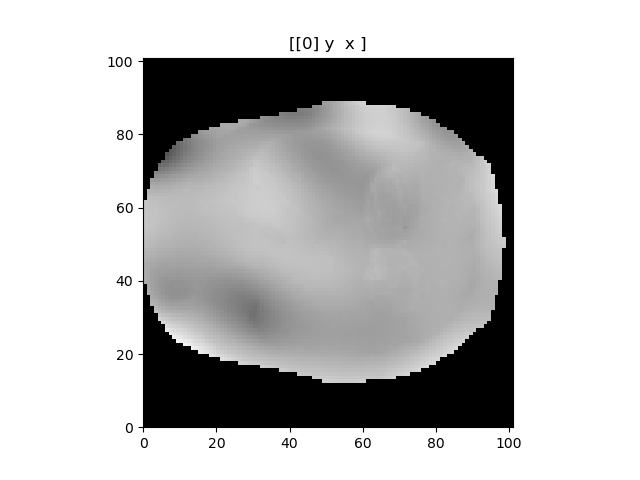

In [85]:
x0 = np.zeros((Nc*Ns), dtype=complex)
x_mls = ShimMLS(sens, mask, x0, show_pbar=True).run()
m = np.reshape(A*x_mls, (Ns, dim, dim))
pl.ImagePlot(m)

This isn't perfect, but it's quite a bit better!